## Binary Classification using a neural network with Pytorch

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import torch # this is the Pytorch pakcage
from torch.utils.data import Dataset as torch_dataset
from torch.utils.data import DataLoader as torch_dataloader
#we only need the mnist data from Keras
from tensorflow.keras.datasets import mnist

### Load the data

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 4s 0us/step


In [3]:
#reshape
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#normalize the value of every pixel into the range of 0 to 1
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'training samples')
print(x_test.shape[0], 'test samples')

60000 training samples
10000 test samples


We choose class-0 and class-1 for binary classification

In [4]:
x_train=x_train[(y_train==0)|(y_train==1)]
y_train=y_train[(y_train==0)|(y_train==1)]
x_test=x_test[(y_test==0)|(y_test==1)]
y_test=y_test[(y_test==0)|(y_test==1)]

create a validation set

In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=0)
print('train:', x_train.shape, y_train.shape)
print('validation:', x_val.shape, y_val.shape)
print('test:', x_test.shape, y_test.shape)

train: (11398, 784) (11398,)
validation: (1267, 784) (1267,)
test: (2115, 784) (2115,)


show the images

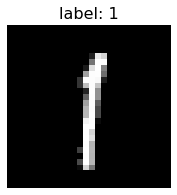

<Figure size 432x288 with 0 Axes>

In [6]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(0, x_train.shape[0], 1000):
    I = x_train[n,:].reshape(28,28)
    ax.imshow(I, cmap='gray')
    ax.set_title('label: ' + str(int(y_train[n])), fontsize=16)
    ax.axis('off')
    plt.draw()
    display.clear_output(wait=True)
    display.display(fig)
    plt.pause(0.1) 

### define a dataset to hold/represent the data
`MyDataset` is a Python class, derived from `torch_dataset`

In [7]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):
        # self.X[idx] is numpy array, we need to convert it to torch tensor
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32) #it needs to be float, not int
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [8]:
dataset_train = MyDataset(x_train, y_train)
dataset_val = MyDataset(x_val, y_val)
dataset_test = MyDataset(x_test, y_test)

In [9]:
# get the first data point in the training set
# dataset_train[0][0] is x0
# dataset_train[0][1] is y0
dataset_train[0][0].shape

torch.Size([784])

In [10]:
# the class label of the first training sample x0
dataset_train[0][1]

tensor(0.)

In [11]:
len(dataset_train) # get the number of data points in the training set

11398

### Create dataloaders which will be used to generate minibatches
batch_size=64 means each minibatch contains 64 data points  <br>
note: the last minibatch may contain less than 64 data points

In [12]:
#we must shuffle data points in the training set, set shuffle=True
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [13]:
dataloader_train.dataset[0] # get the first data point in the training set

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

We can use a dataloader to generate minibatches 

In [14]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        # X contain the data samples in a mini-batch
        # Y contain the class lables of these samples
        print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 784]) torch.Size([64])
1 torch.Size([64, 784]) torch.Size([64])
2 torch.Size([64, 784]) torch.Size([64])
3 torch.Size([64, 784]) torch.Size([64])
4 torch.Size([64, 784]) torch.Size([64])
5 torch.Size([64, 784]) torch.Size([64])
6 torch.Size([64, 784]) torch.Size([64])
7 torch.Size([64, 784]) torch.Size([64])
8 torch.Size([64, 784]) torch.Size([64])
9 torch.Size([64, 784]) torch.Size([64])
10 torch.Size([64, 784]) torch.Size([64])
11 torch.Size([64, 784]) torch.Size([64])
12 torch.Size([64, 784]) torch.Size([64])
13 torch.Size([64, 784]) torch.Size([64])
14 torch.Size([64, 784]) torch.Size([64])
15 torch.Size([64, 784]) torch.Size([64])
16 torch.Size([64, 784]) torch.Size([64])
17 torch.Size([64, 784]) torch.Size([64])
18 torch.Size([64, 784]) torch.Size([64])
19 torch.Size([64, 784]) torch.Size([64])
20 torch.Size([64, 784]) torch.Size([64])
21 torch.Size([64, 784]) torch.Size([64])
22 torch.Size([64, 784]) torch.Size([64])
23 torch.Size([64, 784]) torch.Size([64])
24

In [15]:
len(dataloader_train) # get the number of minibatches

179

### Now, let's build a neural network that does binary classification

In [16]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, 1)
    def forward(self, x):
        x=nnF.relu(self.layer1(x)) # same as x=self.layer1(x); x=nnF.relu(x)
        x=nnF.relu(self.layer2(x))
        z=self.layer3(x)
        # we need to do this
        z=z.view(-1) 
        #do not use sigmoid if we use binary_cross_entropy_with_logits loss in pytorch
        #z is called logits
        #y=nnF.sigmoid(z) 
        return z

create an instance object of the class

In [17]:
model=Net(input_dim=784, n_units=256)

In [18]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=1, bias=True)
)

create an optimizer that does stochastic gradient descent <br>
send the parameters of the model to the optimizer

In [19]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

define a function to train the neural network in one epoch

In [20]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Z = model(X) #forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y) #compute loss
        loss.backward() #backward pass
        optimizer.step() #update parameters
        loss_train+=loss.item() #record the loss
        #make prediction, do not need sigmoid
        Yp = (Z.data>0).to(torch.int64)    
        #measure accuracy on this batch
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset)
    return loss_train, acc_train

define a function to evaluate the neural network on the validation set or the testing set

In [21]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0 
    with torch.no_grad(): # tell Pytorch not to build graph in this section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)    
            loss_test+=loss.item()
            #make prediction, do not need sigmoid
            Yp = (Z.data>0).to(torch.int64) 
            acc_test+= torch.sum(Yp==Y).item()
    loss_test/=len(dataloader)    
    acc_test/=len(dataloader.dataset)
    return loss_test, acc_test

define a function to save the model to a file

In [22]:
def save_checkpoint(filename, model, optimizer, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
               filename)
    print('saved:', filename)

define a function to load the model from a file

In [23]:
def load_checkpoint(filename, model, optimizer, device):
    checkpoint=torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

train the neural network model for many epochs

In [24]:
loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]

In [25]:
for epoch in range(0, 10):    
    #-------- perform training --------------------------------
    loss_train, acc_train =train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- perform validation --------------------------------
    loss_val, acc_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)
    #------ save model ------------------
    #you can choose to save model every 10 epochs
    #if epoch %10 == 0
    filename='NN_binary_classification_Pytorch_e'+str(epoch)+'.pt'
    save_checkpoint(filename, model, optimizer, epoch)

Train Epoch: 0 [0/11398 (0%)]	Loss: 0.690732
Train Epoch: 0 [6400/11398 (56%)]	Loss: 0.004947
epoch 0 training loss: 0.1257992847351092 acc: 0.9772767152131953
epoch 0 validation loss: 0.005916624015662819 acc: 0.9992107340173638
saved: NN_binary_classification_Pytorch_e0.pt
Train Epoch: 1 [0/11398 (0%)]	Loss: 0.002532
Train Epoch: 1 [6400/11398 (56%)]	Loss: 0.005075
epoch 1 training loss: 0.006731089329745038 acc: 0.9981575715037726
epoch 1 validation loss: 0.004163743666140363 acc: 0.9992107340173638
saved: NN_binary_classification_Pytorch_e1.pt
Train Epoch: 2 [0/11398 (0%)]	Loss: 0.001813
Train Epoch: 2 [6400/11398 (56%)]	Loss: 0.000599
epoch 2 training loss: 0.004709107238752507 acc: 0.9986839796455519
epoch 2 validation loss: 0.004025648755487055 acc: 0.9984214680347278
saved: NN_binary_classification_Pytorch_e2.pt
Train Epoch: 3 [0/11398 (0%)]	Loss: 0.000878
Train Epoch: 3 [6400/11398 (56%)]	Loss: 0.000670
epoch 3 training loss: 0.0039441447682918036 acc: 0.998859449026145
epoch 

draw the curves of loss vs epoch

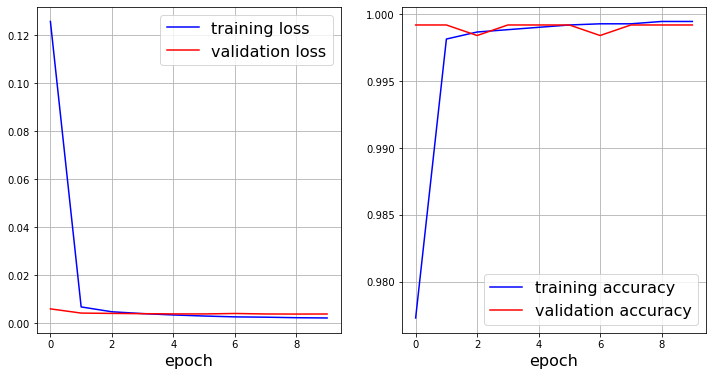

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax[0].plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].plot(np.arange(0,len(acc_train_list)), acc_train_list, '-b', label='training accuracy')
ax[1].plot(np.arange(0,len(acc_val_list)), acc_val_list, '-r', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
For this simple example, we can skip this step

In [27]:
#to change the learning rate during traning, we may do this
for g in optimizer.param_groups:
    g['lr']=0.001

after training, we load the best model and evaluate the model on the test set

In [28]:
np.argmax(acc_val_list)

0

In [29]:
filename_best='NN_binary_classification_Pytorch_e5.pt'
load_checkpoint(filename_best, model, optimizer, device)

In [30]:
loss_test, acc_test = test(model, dataloader_test, device)
print('test loss:', loss_test)
print('test accuracy', acc_test)

test loss: 0.002097995301215526
test accuracy 0.9990543735224586


apply the model to some data points in the test set

In [31]:
x=dataloader_test.dataset[0][0]
x=x.view(1,784).to(device)
z=model(x)
z.size()

torch.Size([1])

In [32]:
yp=(z>0).to(torch.int64)
yp

tensor([1], device='cuda:0')

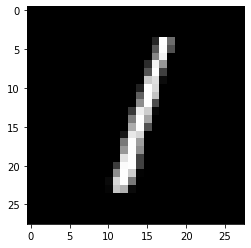

In [33]:
#show the image x
x=x.detach().cpu().numpy()
plt.imshow(x.reshape(28,28), cmap='gray')